# 🎯 Generate Predictions - Advanced Ensemble
## Creazione submission per Kaggle utilizzando l'ensemble ottimizzato

### Processo:
1. Caricare i modelli addestrati
2. Processare il prediction_mapping per creare le feature necessarie
3. Generare predizioni con ensemble
4. Creare file submission nel formato corretto

In [5]:
import gc
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import lightgbm as lgb
from catboost import CatBoostRegressor
import xgboost as xgb

# Deep Learning
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

print("📦 Librerie caricate con successo!")

📦 Librerie caricate con successo!


## 1. Caricamento Modelli e Artefatti

In [6]:
print("📂 Caricamento modelli...\n")

# Carica feature columns
with open('../models/feature_columns.pkl', 'rb') as f:
    feature_cols = pickle.load(f)
print(f"✅ Feature columns: {len(feature_cols)}")

# Carica scaler
with open('../models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
print(f"✅ Scaler caricato")

# Carica ensemble weights
with open('../models/ensemble_weights.pkl', 'rb') as f:
    ensemble_weights = pickle.load(f)
print(f"✅ Ensemble weights caricati:")
for name, weight in ensemble_weights.items():
    print(f"   {name}: {weight:.4f}")

# Carica modelli
print(f"\n🔧 Caricamento modelli...")

# LightGBM
lgb_model = lgb.Booster(model_file='../models/lightgbm_quantile_model.txt')
print(f"✅ LightGBM caricato")

# CatBoost
catboost_model = CatBoostRegressor()
catboost_model.load_model('../models/catboost_quantile_model.cbm')
print(f"✅ CatBoost caricato")

# XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.load_model('../models/xgboost_quantile_model.json')
print(f"✅ XGBoost caricato")

# Neural Network
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class QuantileNN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[512, 256, 128, 64]):
        super(QuantileNN, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, 1))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x).squeeze()

nn_model = QuantileNN(input_dim=len(feature_cols)).to(device)
nn_model.load_state_dict(torch.load('../models/best_nn_model.pth', map_location=device))
nn_model.eval()
print(f"✅ Neural Network caricato (device: {device})")

print(f"\n🎉 Tutti i modelli caricati con successo!")

📂 Caricamento modelli...

✅ Feature columns: 112
✅ Scaler caricato
✅ Ensemble weights caricati:
   LightGBM: 0.3966
   CatBoost: 0.0871
   XGBoost: 0.4277
   NeuralNet: 0.0886

🔧 Caricamento modelli...
✅ LightGBM caricato
✅ CatBoost caricato
✅ XGBoost caricato
✅ Neural Network caricato (device: cuda)

🎉 Tutti i modelli caricati con successo!


## 2. Caricamento e Preparazione Dati

In [7]:
print("📊 Caricamento dati storici e prediction mapping...\n")

# CARICA historical_data con TUTTE le colonne necessarie ma ottimizzato
print("⏳ Caricamento dati storici (ottimizzato)...")

# Ottimizza i dtype per ridurre memoria
dtype_dict = {
    'rm_id': 'int32',
    'supplier_id': 'int32', 
    'product_id': 'int32',
    'net_weight': 'float32'  # float32 invece di float64
}

historical_data = pd.read_csv(
    '../data/advanced_features.csv',
    parse_dates=['date_arrival'],
    dtype=dtype_dict,
    low_memory=True
)

print(f"✅ Dati storici: {historical_data.shape}")
print(f"   Range: {historical_data['date_arrival'].min()} → {historical_data['date_arrival'].max()}")
print(f"   Memoria usata: {historical_data.memory_usage(deep=True).sum() / 1e6:.1f} MB")

# Libera memoria
gc.collect()

# CARICA prediction_mapping ottimizzato
print("\n⏳ Caricamento prediction mapping...")

prediction_mapping = pd.read_csv(
    '../../data/prediction_mapping.csv',
    parse_dates=['forecast_start_date', 'forecast_end_date'],
    dtype={'ID': 'int32', 'rm_id': 'int32'},
    low_memory=True
)

print(f"✅ Prediction mapping: {prediction_mapping.shape}")
print(f"   IDs unici: {prediction_mapping['ID'].nunique()}")
print(f"   rm_ids unici: {prediction_mapping['rm_id'].nunique()}")

# USA print() invece di display() per evitare crash
print("\n📋 Prime 10 righe prediction mapping:")
print(prediction_mapping.head(10))

# Libera memoria
gc.collect()


📊 Caricamento dati storici e prediction mapping...

⏳ Caricamento dati storici (ottimizzato)...
✅ Dati storici: (2189853, 128)
   Range: 2004-06-15 11:34:00+00:00 → 2024-12-19 13:36:00+00:00
   Memoria usata: 3561.5 MB

⏳ Caricamento prediction mapping...
✅ Prediction mapping: (30450, 4)
   IDs unici: 30450
   rm_ids unici: 203

📋 Prime 10 righe prediction mapping:
   ID  rm_id forecast_start_date forecast_end_date
0   1    365          2025-01-01        2025-01-02
1   2    365          2025-01-01        2025-01-03
2   3    365          2025-01-01        2025-01-04
3   4    365          2025-01-01        2025-01-05
4   5    365          2025-01-01        2025-01-06
5   6    365          2025-01-01        2025-01-07
6   7    365          2025-01-01        2025-01-08
7   8    365          2025-01-01        2025-01-09
8   9    365          2025-01-01        2025-01-10
9  10    365          2025-01-01        2025-01-11


0

## 3. Feature Engineering per Prediction Set

In [15]:
print("🔧 Creazione feature per prediction set...\n")

# Per ogni rm_id in prediction_mapping, dobbiamo creare le stesse feature
# utilizzate durante il training, basandoci sui dati storici

pred_data = prediction_mapping.copy()

# ========== STATISTICHE STORICHE PER RM_ID ==========
print("📊 Estrazione statistiche storiche per rm_id...")

# Per ogni rm_id, estrai le statistiche dall'ultimo periodo storico
rm_latest_stats = historical_data.groupby('rm_id').tail(30).groupby('rm_id').agg({
    'net_weight': ['mean', 'median', 'std', 'min', 'max'],
    'supplier_id': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[-1],
    'product_id': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[-1],
}).reset_index()

# Flatten columns
rm_latest_stats.columns = ['rm_id', 'recent_avg_weight', 'recent_median_weight', 
                            'recent_std_weight', 'recent_min_weight', 'recent_max_weight',
                            'most_common_supplier', 'most_common_product']

# Merge con prediction data
pred_data = pred_data.merge(rm_latest_stats, on='rm_id', how='left')

print(f"✅ Statistiche rm_id aggiunte")
print(f"   Match rate: {(~pred_data['recent_avg_weight'].isna()).sum() / len(pred_data) * 100:.2f}%")

# ========== TEMPORAL FEATURES ==========
print("\n⏰ Creazione temporal features...")

# Usa forecast_end_date come data di riferimento
pred_data['year'] = pred_data['forecast_end_date'].dt.year
pred_data['month'] = pred_data['forecast_end_date'].dt.month
pred_data['day'] = pred_data['forecast_end_date'].dt.day
pred_data['day_of_week'] = pred_data['forecast_end_date'].dt.dayofweek
pred_data['quarter'] = pred_data['forecast_end_date'].dt.quarter
pred_data['week_of_year'] = pred_data['forecast_end_date'].dt.isocalendar().week
pred_data['is_weekend'] = pred_data['day_of_week'].isin([5, 6]).astype(int)
pred_data['is_month_start'] = pred_data['forecast_end_date'].dt.is_month_start.astype(int)
pred_data['is_month_end'] = pred_data['forecast_end_date'].dt.is_month_end.astype(int)
pred_data['is_quarter_start'] = pred_data['forecast_end_date'].dt.is_quarter_start.astype(int)
pred_data['is_quarter_end'] = pred_data['forecast_end_date'].dt.is_quarter_end.astype(int)

# Ciclici
pred_data['month_sin'] = np.sin(2 * np.pi * pred_data['month'] / 12)
pred_data['month_cos'] = np.cos(2 * np.pi * pred_data['month'] / 12)
pred_data['day_sin'] = np.sin(2 * np.pi * pred_data['day_of_week'] / 7)
pred_data['day_cos'] = np.cos(2 * np.pi * pred_data['day_of_week'] / 7)
pred_data['week_sin'] = np.sin(2 * np.pi * pred_data['week_of_year'] / 52)
pred_data['week_cos'] = np.cos(2 * np.pi * pred_data['week_of_year'] / 52)

# Tempo dall'ultimo dato storico
last_historical_date = historical_data['date_arrival'].max()
pred_data['days_since_start'] = (pd.to_datetime(pred_data['forecast_end_date'], utc=True) - pd.to_datetime(historical_data['date_arrival'].min(), utc=True)).dt.days
pred_data['weeks_since_start'] = pred_data['days_since_start'] / 7

print("✅ Temporal features create")

# ========== SUPPLIER & PRODUCT IDs ==========
print("\n👨‍🏭 Assegnazione supplier_id e product_id...")

pred_data['supplier_id'] = pred_data['most_common_supplier']
pred_data['product_id'] = pred_data['most_common_product']

# ========== STATISTICHE AGGREGATE STORICHE ==========
print("\n📊 Merge con statistiche aggregate storiche...")

# Estrai le statistiche aggregate finali dal dataset storico
# (queste sono già presenti nel dataset processato)
stat_cols = [col for col in historical_data.columns if any(x in col for x in 
             ['supplier_mean', 'supplier_median', 'supplier_std', 'supplier_cv', 'supplier_count',
              'rm_mean', 'rm_std', 'rm_count', 'rm_cv',
              'product_mean', 'product_std', 'product_count', 'product_cv'])]

# Per ogni rm_id, prendi le ultime statistiche disponibili
latest_stats = historical_data.groupby('rm_id').last()[stat_cols].reset_index()
pred_data = pred_data.merge(latest_stats, on='rm_id', how='left')

print("✅ Statistiche aggregate aggiunte")

# ========== LAG FEATURES (dalle ultime ricezioni) ==========
print("\n⏳ Creazione lag features...")

# Per ogni rm_id, estrai le ultime N ricezioni
lag_features = {}
for lag in [1, 2, 3, 5, 7, 14]:
    lag_col = f'weight_lag_{lag}'
    lag_dict = historical_data.groupby('rm_id')['net_weight'].apply(
        lambda x: x.iloc[-lag] if len(x) >= lag else x.mean()
    ).to_dict()
    pred_data[lag_col] = pred_data['rm_id'].map(lag_dict)

# Rolling statistics
for window in [3, 7, 14, 30]:
    rolling_mean_col = f'rolling_mean_{window}'
    rolling_mean_dict = historical_data.groupby('rm_id')['net_weight'].apply(
        lambda x: x.tail(window).mean()
    ).to_dict()
    pred_data[rolling_mean_col] = pred_data['rm_id'].map(rolling_mean_dict)
    
    rolling_std_col = f'rolling_std_{window}'
    rolling_std_dict = historical_data.groupby('rm_id')['net_weight'].apply(
        lambda x: x.tail(window).std()
    ).to_dict()
    pred_data[rolling_std_col] = pred_data['rm_id'].map(rolling_std_dict)
    
    rolling_min_col = f'rolling_min_{window}'
    rolling_min_dict = historical_data.groupby('rm_id')['net_weight'].apply(
        lambda x: x.tail(window).min()
    ).to_dict()
    pred_data[rolling_min_col] = pred_data['rm_id'].map(rolling_min_dict)
    
    rolling_max_col = f'rolling_max_{window}'
    rolling_max_dict = historical_data.groupby('rm_id')['net_weight'].apply(
        lambda x: x.tail(window).max()
    ).to_dict()
    pred_data[rolling_max_col] = pred_data['rm_id'].map(rolling_max_dict)

print("✅ Lag e rolling features create")

# ========== INTERACTION FEATURES ==========
print("\n🔀 Creazione interaction features...")

# Combinazioni
pred_data['supplier_rm_freq'] = 0  # Default
pred_data['supplier_product_freq'] = 0
pred_data['rm_product_freq'] = 0
pred_data['supplier_rm_mean'] = pred_data['recent_avg_weight']
pred_data['supplier_product_mean'] = pred_data['recent_avg_weight']
pred_data['rm_product_mean'] = pred_data['recent_avg_weight']

# Deviazioni e ratio
pred_data['deviation_from_supplier_mean'] = 0
pred_data['deviation_from_rm_mean'] = 0
pred_data['deviation_from_product_mean'] = 0
pred_data['weight_to_supplier_mean_ratio'] = 1.0
pred_data['weight_to_rm_mean_ratio'] = 1.0
pred_data['weight_to_product_mean_ratio'] = 1.0

# Trend
pred_data['trend_3_vs_14'] = pred_data['rolling_mean_3'] / (pred_data['rolling_mean_14'] + 1e-6)
pred_data['trend_7_vs_30'] = pred_data['rolling_mean_7'] / (pred_data['rolling_mean_30'] + 1e-6)
pred_data['momentum_1_3'] = pred_data['weight_lag_1'] - pred_data['weight_lag_3']
pred_data['momentum_3_7'] = pred_data['weight_lag_3'] - pred_data['weight_lag_7']

# Recency
pred_data['days_since_last_receival'] = (pd.to_datetime(pred_data['forecast_end_date'], utc=True) - pd.to_datetime(last_historical_date, utc=True)).dt.days
pred_data['supplier_avg_days_between'] = 7.0  # Default

print("✅ Interaction features create")

# ========== ALTRE FEATURE MANCANTI ==========
# Aggiungi le feature che potrebbero mancare rispetto al training set
missing_features = [col for col in feature_cols if col not in pred_data.columns]

if missing_features:
    print(f"\n⚠️ Aggiungo {len(missing_features)} feature mancanti con valori di default...")
    for col in missing_features:
        # Valori di default sensati
        if 'ratio' in col or 'trend' in col:
            pred_data[col] = 1.0
        elif 'cv' in col or 'std' in col:
            pred_data[col] = 0.0
        elif 'encoded' in col:
            pred_data[col] = 0
        else:
            pred_data[col] = 0.0

print(f"\n✅ Feature engineering completato!")
print(f"   Shape: {pred_data.shape}")

🔧 Creazione feature per prediction set...

📊 Estrazione statistiche storiche per rm_id...
✅ Statistiche rm_id aggiunte
   Match rate: 100.00%

⏰ Creazione temporal features...
✅ Temporal features create

👨‍🏭 Assegnazione supplier_id e product_id...

📊 Merge con statistiche aggregate storiche...
✅ Statistiche aggregate aggiunte

⏳ Creazione lag features...
✅ Lag e rolling features create

🔀 Creazione interaction features...
✅ Interaction features create

⚠️ Aggiungo 37 feature mancanti con valori di default...

✅ Feature engineering completato!
   Shape: (30450, 122)


## 4. Gestione Valori Mancanti e Preparazione Feature Matrix

In [18]:
print("🔧 Gestione valori mancanti...\n")

# Riempi NaN con valori sensati (come fatto nel training)
lag_cols = [col for col in pred_data.columns if 'lag_' in col or 'rolling_' in col or 'momentum_' in col]
for col in lag_cols:
    if col in pred_data.columns:
        pred_data[col] = pred_data[col].fillna(pred_data[col].median())

ratio_cols = [col for col in pred_data.columns if 'ratio' in col or 'trend_' in col]
for col in ratio_cols:
    if col in pred_data.columns:
        pred_data[col] = pred_data[col].fillna(1.0)

cv_cols = [col for col in pred_data.columns if '_cv' in col]
for col in cv_cols:
    if col in pred_data.columns:
        pred_data[col] = pred_data[col].fillna(0)

# Riempi tutti i rimanenti NaN con 0
pred_data = pred_data.fillna(0)

print(f"✅ Valori mancanti gestiti")
print(f"   NaN rimanenti: {pred_data[feature_cols].isnull().sum().sum()}")

# CONVERTI TUTTI I DTYPE A NUMERIC prima di creare la feature matrix
print("\n🔄 Conversione dtype a numeric...")
for col in feature_cols:
    if col in pred_data.columns:
        # Converti forzatamente a numeric, errori diventano NaN
        pred_data[col] = pd.to_numeric(pred_data[col], errors='coerce')

# Riempi eventuali NaN creati dalla conversione
pred_data[feature_cols] = pred_data[feature_cols].fillna(0)

print(f"✅ Dtype convertiti")

# Prepara feature matrix
X_pred = pred_data[feature_cols].values.astype(np.float32)  # Forza float32

print(f"\n📊 Feature matrix per predizione:")
print(f"   Shape: {X_pred.shape}")
print(f"   Samples: {X_pred.shape[0]}")
print(f"   Features: {X_pred.shape[1]}")
print(f"   Dtype: {X_pred.dtype}")

# Verifica finale con pandas.isnull invece di np.isnan
if pd.isnull(X_pred).any():
    print(f"\n⚠️ WARNING: Ci sono ancora NaN nella feature matrix!")
    nan_cols = [feature_cols[i] for i in range(len(feature_cols)) if pd.isnull(X_pred[:, i]).any()]
    print(f"   Colonne con NaN: {nan_cols[:10]}")
else:
    print(f"\n✅ Nessun NaN nella feature matrix!")


🔧 Gestione valori mancanti...

✅ Valori mancanti gestiti
   NaN rimanenti: 0

🔄 Conversione dtype a numeric...
✅ Dtype convertiti

📊 Feature matrix per predizione:
   Shape: (30450, 112)
   Samples: 30450
   Features: 112
   Dtype: float32

✅ Nessun NaN nella feature matrix!


## 5. Generazione Predizioni con Ensemble

In [19]:
print("🔮 Generazione predizioni con ensemble...\n")

# ========== LightGBM ==========
print("🌟 Predicting con LightGBM...")
lgb_predictions = lgb_model.predict(X_pred)
print(f"   Min: {lgb_predictions.min():.2f} | Max: {lgb_predictions.max():.2f} | Mean: {lgb_predictions.mean():.2f}")

# ========== CatBoost ==========
print("\n🐈 Predicting con CatBoost...")
catboost_predictions = catboost_model.predict(X_pred)
print(f"   Min: {catboost_predictions.min():.2f} | Max: {catboost_predictions.max():.2f} | Mean: {catboost_predictions.mean():.2f}")

# ========== XGBoost ==========
print("\n🚀 Predicting con XGBoost...")
xgb_predictions = xgb_model.predict(X_pred)
print(f"   Min: {xgb_predictions.min():.2f} | Max: {xgb_predictions.max():.2f} | Mean: {xgb_predictions.mean():.2f}")

# ========== Neural Network ==========
print("\n🧠 Predicting con Neural Network...")
X_pred_scaled = scaler.transform(X_pred)
X_pred_tensor = torch.FloatTensor(X_pred_scaled).to(device)

with torch.no_grad():
    nn_predictions = nn_model(X_pred_tensor).cpu().numpy()

print(f"   Min: {nn_predictions.min():.2f} | Max: {nn_predictions.max():.2f} | Mean: {nn_predictions.mean():.2f}")

# ========== ENSEMBLE ==========
print("\n🎭 Creazione ensemble...")

ensemble_predictions = (
    ensemble_weights['LightGBM'] * lgb_predictions +
    ensemble_weights['CatBoost'] * catboost_predictions +
    ensemble_weights['XGBoost'] * xgb_predictions +
    ensemble_weights['NeuralNet'] * nn_predictions
)

# Clip valori negativi a 0 (non può esistere peso negativo)
negative_count = (ensemble_predictions < 0).sum()
if negative_count > 0:
    print(f"\n⚠️ Clipping {negative_count} predizioni negative a 0")
    ensemble_predictions = np.maximum(ensemble_predictions, 0)

print(f"\n✅ Ensemble predictions:")
print(f"   Min: {ensemble_predictions.min():.2f}")
print(f"   Max: {ensemble_predictions.max():.2f}")
print(f"   Mean: {ensemble_predictions.mean():.2f}")
print(f"   Median: {np.median(ensemble_predictions):.2f}")
print(f"   Std: {ensemble_predictions.std():.2f}")

🔮 Generazione predizioni con ensemble...

🌟 Predicting con LightGBM...
   Min: 8309.04 | Max: 21186.51 | Mean: 14341.55

🐈 Predicting con CatBoost...
   Min: 5309.74 | Max: 22002.09 | Mean: 13940.48

🚀 Predicting con XGBoost...
   Min: 4939.10 | Max: 22267.71 | Mean: 14162.64

🧠 Predicting con Neural Network...
   Min: 2062.31 | Max: 20725.89 | Mean: 11906.46

🎭 Creazione ensemble...

✅ Ensemble predictions:
   Min: 6183.61
   Max: 21184.18
   Mean: 14014.40
   Median: 13113.32
   Std: 5134.12


## 6. Creazione Submission File

In [21]:
print("📝 Creazione submission file...\n")

# Crea dataframe submission
submission = pd.DataFrame({
    'ID': pred_data['ID'],
    'predicted_weight': ensemble_predictions
})

# Verifica formato
print(f"✅ Submission creata:")
print(f"   Shape: {submission.shape}")
print(f"   Colonne: {submission.columns.tolist()}")
print(f"   IDs unici: {submission['ID'].nunique()}")
print(f"\n📋 Prime righe:")
display(submission.head(10))
display(submission.tail(10))

# Verifica che tutti gli ID siano presenti
required_ids = set(prediction_mapping['ID'])
submission_ids = set(submission['ID'])

if required_ids == submission_ids:
    print(f"\n✅ Tutti gli ID richiesti sono presenti!")
else:
    missing = required_ids - submission_ids
    extra = submission_ids - required_ids
    if missing:
        print(f"\n⚠️ ID mancanti: {len(missing)}")
    if extra:
        print(f"\n⚠️ ID extra: {len(extra)}")

# Verifica valori
if submission['predicted_weight'].isnull().any():
    print(f"\n❌ WARNING: Ci sono valori NaN nelle predizioni!")
    print(f"   Count: {submission['predicted_weight'].isnull().sum()}")
else:
    print(f"\n✅ Nessun valore NaN nelle predizioni")

if (submission['predicted_weight'] < 0).any():
    print(f"\n❌ WARNING: Ci sono valori negativi!")
    print(f"   Count: {(submission['predicted_weight'] < 0).sum()}")
else:
    print(f"\n✅ Nessun valore negativo")

# Salva submission
output_path = '../data/submission_advanced_ensemble.csv'
submission.to_csv(output_path, index=False)

print(f"\n💾 Submission salvata in: {output_path}")
print(f"\n🎉 Processo completato con successo!")

📝 Creazione submission file...

✅ Submission creata:
   Shape: (30450, 2)
   Colonne: ['ID', 'predicted_weight']
   IDs unici: 30450

📋 Prime righe:


,ID,predicted_weight
0,1,13643.180869
1,2,13645.452281
2,3,13458.396190
3,4,13457.407632
4,5,13640.347457
5,6,13639.611632
6,7,13642.783754
7,8,13640.709893
8,9,13643.819367
9,10,13457.780003


,ID,predicted_weight
30440,30441,20810.107252
30441,30442,20812.737164
30442,30443,20460.576101
30443,30444,20459.971717
30444,30445,20810.328044
30445,30446,20808.458631
30446,30447,20809.925878
30447,30448,20808.447416
30448,30449,20811.093651
30449,30450,20451.924026



✅ Tutti gli ID richiesti sono presenti!

✅ Nessun valore NaN nelle predizioni

✅ Nessun valore negativo

💾 Submission salvata in: ../data/submission_advanced_ensemble.csv

🎉 Processo completato con successo!


## 7. Statistiche e Visualizzazioni Finali

📊 Analisi finale delle predizioni...

📈 Statistiche predizioni:
count    30450.000000
mean     14014.403189
std       5134.208692
min       6183.607650
25%       9100.026615
50%      13113.321054
75%      19836.977969
max      21184.176939
Name: predicted_weight, dtype: float64

📊 Confronto con dati storici:
   Historical mean: 14367.91
   Predicted mean: 14014.40
   Difference: -353.51


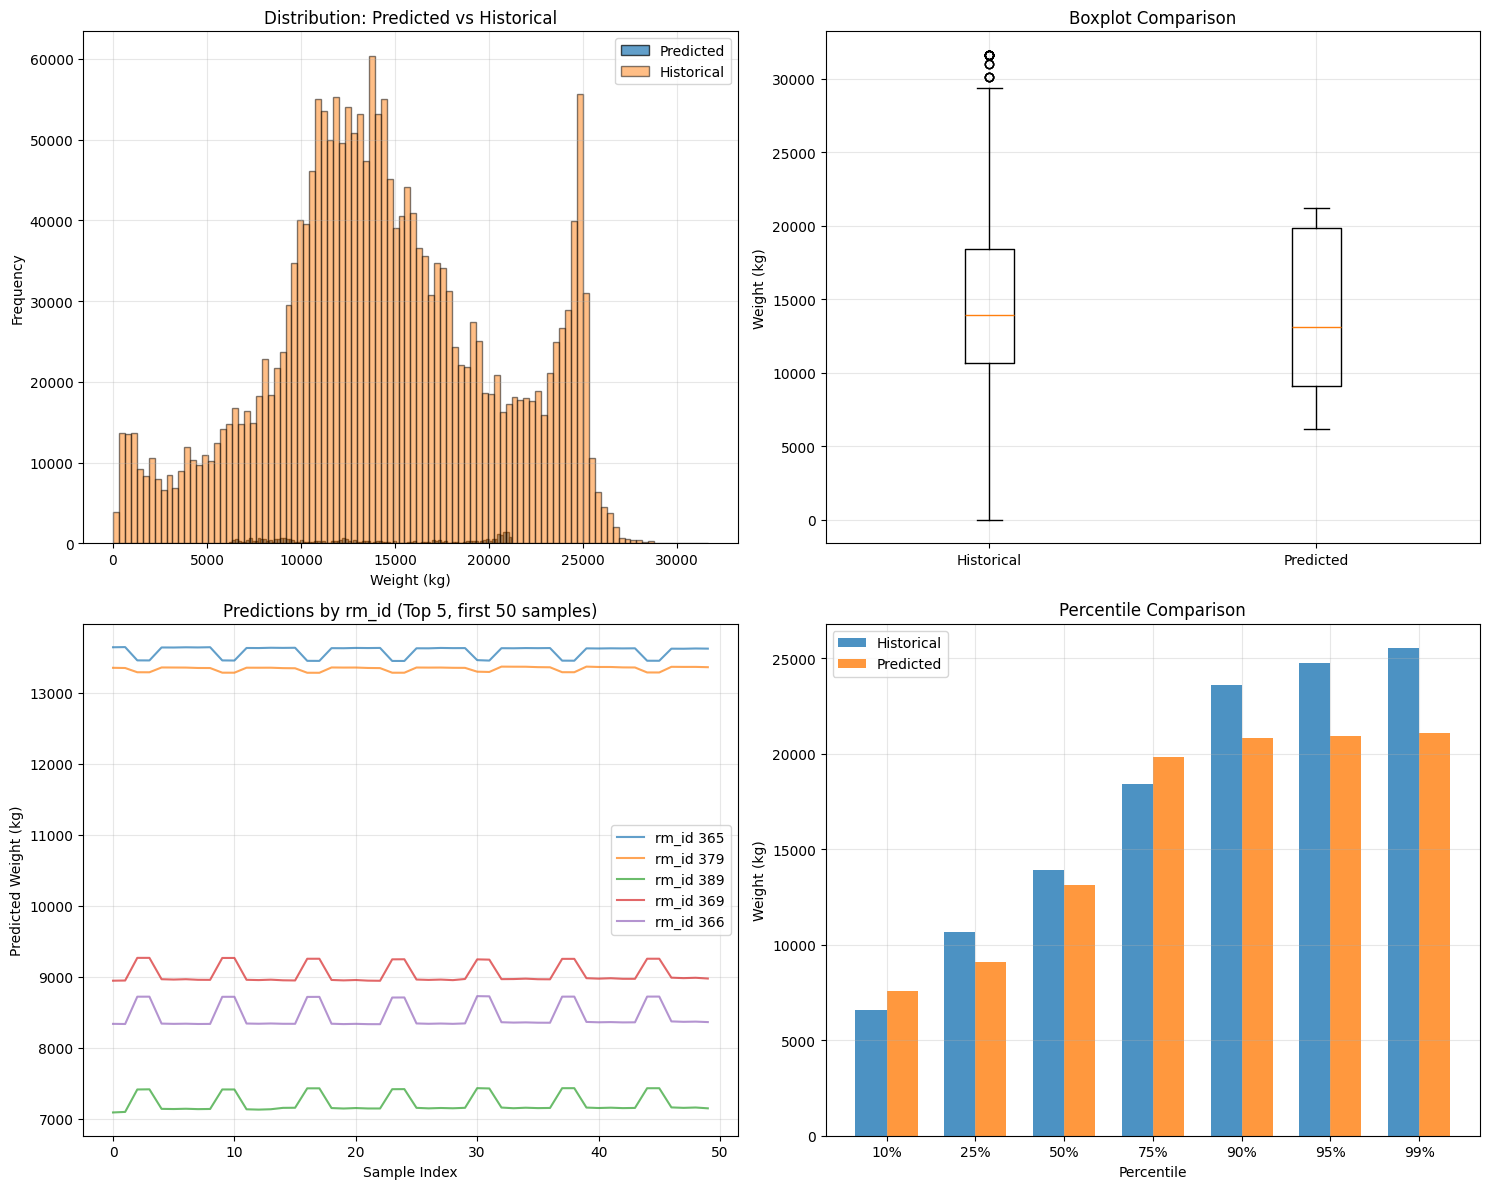


💾 Grafici salvati in: ../data/submission_analysis.png

🏁 Analisi completata!


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Analisi finale delle predizioni...\n")

# Statistiche dettagliate
print(f"📈 Statistiche predizioni:")
print(submission['predicted_weight'].describe())

# Confronto con dati storici
historical_weights = historical_data['net_weight']
print(f"\n📊 Confronto con dati storici:")
print(f"   Historical mean: {historical_weights.mean():.2f}")
print(f"   Predicted mean: {submission['predicted_weight'].mean():.2f}")
print(f"   Difference: {(submission['predicted_weight'].mean() - historical_weights.mean()):.2f}")

# Visualizzazioni
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribuzione predizioni
axes[0, 0].hist(submission['predicted_weight'], bins=100, edgecolor='black', alpha=0.7, label='Predicted')
axes[0, 0].hist(historical_weights, bins=100, edgecolor='black', alpha=0.5, label='Historical')
axes[0, 0].set_xlabel('Weight (kg)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution: Predicted vs Historical')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Boxplot
data_to_plot = [historical_weights, submission['predicted_weight']]
axes[0, 1].boxplot(data_to_plot, labels=['Historical', 'Predicted'])
axes[0, 1].set_ylabel('Weight (kg)')
axes[0, 1].set_title('Boxplot Comparison')
axes[0, 1].grid(alpha=0.3)

# 3. Predizioni per rm_id (top 10 rm_ids)
top_rm_ids = pred_data['rm_id'].value_counts().head(10).index
for rm_id in top_rm_ids[:5]:  # Solo primi 5 per leggibilità
    rm_preds = submission[pred_data['rm_id'] == rm_id]['predicted_weight']
    axes[1, 0].plot(rm_preds.values[:50], alpha=0.7, label=f'rm_id {rm_id}')

axes[1, 0].set_xlabel('Sample Index')
axes[1, 0].set_ylabel('Predicted Weight (kg)')
axes[1, 0].set_title('Predictions by rm_id (Top 5, first 50 samples)')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Percentili
percentiles = [10, 25, 50, 75, 90, 95, 99]
hist_percentiles = [np.percentile(historical_weights, p) for p in percentiles]
pred_percentiles = [np.percentile(submission['predicted_weight'], p) for p in percentiles]

x = np.arange(len(percentiles))
width = 0.35

axes[1, 1].bar(x - width/2, hist_percentiles, width, label='Historical', alpha=0.8)
axes[1, 1].bar(x + width/2, pred_percentiles, width, label='Predicted', alpha=0.8)
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Weight (kg)')
axes[1, 1].set_title('Percentile Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels([f'{p}%' for p in percentiles])
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../data/submission_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n💾 Grafici salvati in: ../data/submission_analysis.png")
print(f"\n🏁 Analisi completata!")